# DVS Benchmark

In [25]:
import asyncio
import csv
import time
from typing import List, Text

import httpx
from faker import Faker
from pydantic import BaseModel, Field
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from pathlib import Path
import dvs.utils.to as TO
from dvs.config import console, settings
from dvs.types.search_request import EncodingType, SearchRequest

## Definitions

In [26]:
# Constants
QUERY_COUNT = 1000
TOP_K = 5
CONCURRENT_USERS = 10
BASE_URL = "http://localhost:8000"
TARGET_BENCHMARK_FILE = Path("data/benchmark_results.csv").resolve()
TARGET_BENCHMARK_FILE.parent.mkdir(parents=True, exist_ok=True)

In [27]:
# Initialization
fake = Faker()
openai_client = settings.openai_client
cache = settings.cache
semaphore = asyncio.Semaphore(CONCURRENT_USERS)

In [28]:
# Models
class RequestRecord(BaseModel):
    timestamp: float = Field(default_factory=lambda: time.time())
    http_method: Text = Field(...)
    endpoint: Text = Field(...)
    status_code: int = Field(default=500)
    response_time_ms: int = Field(default=0)
    payload_size_bytes: int = Field(default=0)
    server_timing: Text = Field(default="")


class TestScenario(BaseModel):
    concurrent_users: int
    request_rate: int
    duration_seconds: int
    endpoints_tested: List[Text]


class BenchmarkSchema(BaseModel):
    test_id: Text
    test_environment: Text
    scenario: TestScenario
    request_records: List[RequestRecord]
    results_summary: Text

In [29]:
# Utilities
async def record_search(
    req: SearchRequest, *, semaphore: "asyncio.Semaphore"
) -> "RequestRecord":
    async with semaphore:
        req_record = RequestRecord(http_method="POST", endpoint="/search")
        async with httpx.AsyncClient(base_url=BASE_URL) as client:
            resp = await client.post("/search", json=req.model_dump(exclude_none=True))
            req_record.status_code = resp.status_code
            req_record.response_time_ms = int(resp.elapsed.total_seconds() * 1000)
            req_record.payload_size_bytes = len(resp.content)
            req_record.server_timing = resp.headers.get("Server-Timing", "") or ""
        return req_record


async def _prepare_base64_vectors(queries: List[Text]) -> List[Text]:
    vectors = await TO.queries_to_vectors_with_cache(
        queries,
        cache=cache,
        openai_client=openai_client,
        model=settings.EMBEDDING_MODEL,
        dimensions=settings.EMBEDDING_DIMENSIONS,
    )
    base64_vectors = [TO.vector_to_base64(vec) for vec in vectors]
    return base64_vectors

## Prepare queries

In [30]:
console.print(f"Preparing {QUERY_COUNT} queries...")
base64_vectors = await _prepare_base64_vectors(
    [fake.sentence() for _ in range(QUERY_COUNT)]
)
console.print(f"Prepared {len(base64_vectors)} queries.")

Preparing 1000 queries...

Prepared 1000 queries.

## Run benchmark - Concurrent Clients


In [31]:
console.print(f"Running benchmark with {CONCURRENT_USERS} concurrent clients...")
tasks = [
    asyncio.create_task(
        record_search(
            SearchRequest(query=base64_vec, top_k=TOP_K, encoding=EncodingType.BASE64),
            semaphore=semaphore,
        )
    )
    for base64_vec in base64_vectors
]
records: List[RequestRecord] = []
for future in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
    result = await future
    records.append(result)
records.sort(key=lambda x: x.timestamp)

with open(TARGET_BENCHMARK_FILE, "w") as f:
    writer = csv.writer(f)
    writer.writerow(records[0].model_dump().keys())
    for record in records:
        writer.writerow(record.model_dump().values())

Running benchmark with 10 concurrent clients...

100%|██████████| 1000/1000 [00:09<00:00, 110.03it/s]


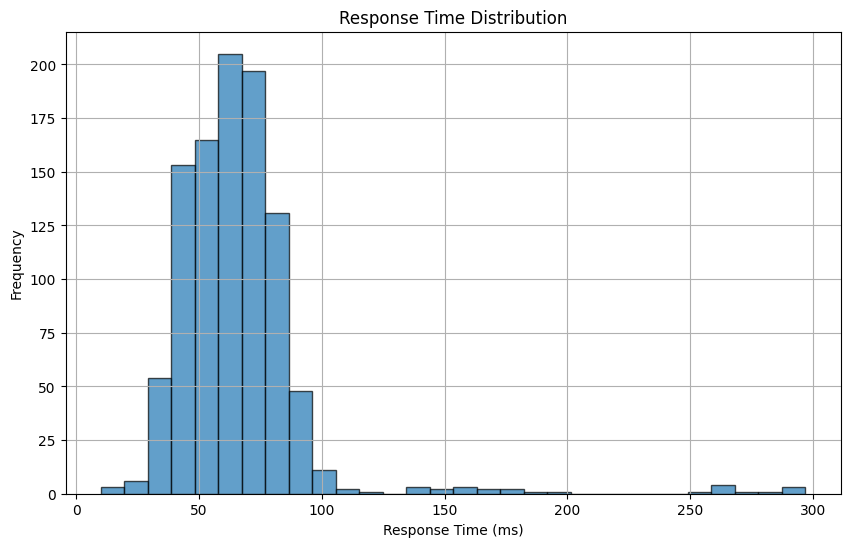

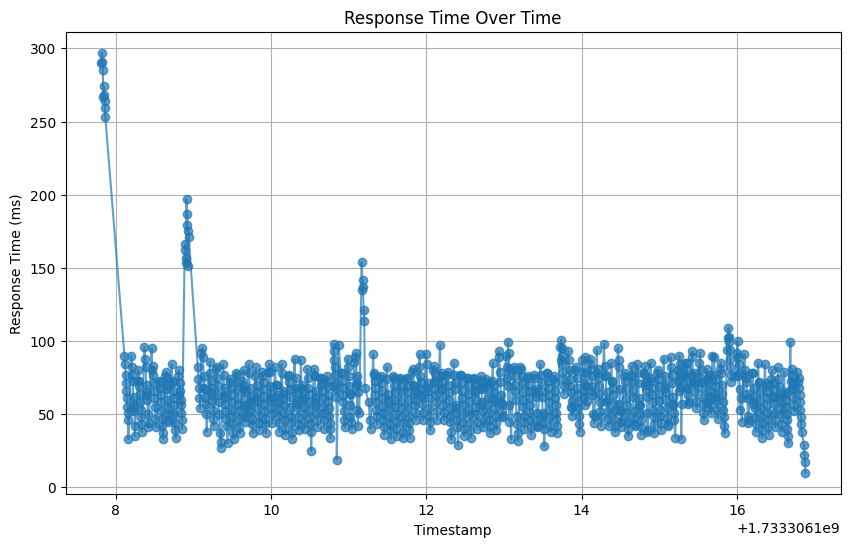

In [32]:
# Load the benchmark results
df = pd.read_csv(TARGET_BENCHMARK_FILE)

# Plot the response time distribution
plt.figure(figsize=(10, 6))
plt.hist(df["response_time_ms"], bins=30, edgecolor="k", alpha=0.7)
plt.title("Response Time Distribution")
plt.xlabel("Response Time (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot the response time over time
plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], df["response_time_ms"], marker="o", linestyle="-", alpha=0.7)
plt.title("Response Time Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Response Time (ms)")
plt.grid(True)
plt.show()